In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:
files = os.listdir('./Data/')

In [60]:
df_mean = pd.DataFrame(columns = ['TIME','BIKE STANDS','AVAILABLE BIKE STANDS','AVAILABLE BIKES'])
for file in files:
    df = pd.read_csv(f"./Data/{file}")
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.drop(['LAST UPDATED','NAME','STATUS','STATION ID',
            'ADDRESS','LATITUDE','LONGITUDE'], axis=1, inplace=True)
    df = df.sort_values(by=['TIME'])

    df = df.groupby('TIME').sum().reset_index()
    df['BIKE USAGE'] =  -df['AVAILABLE BIKES'].diff()
    df['BIKE USAGE'] = df['BIKE USAGE'].apply(lambda x: 0 if x < 0 else x)
    df['BIKE USAGE'].fillna(0, inplace=True)
    df_mean = pd.concat([df_mean,df.resample('D',on='TIME').sum().reset_index()]
                         ,ignore_index=True)
df_mean.dropna(inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_21188\1149182107.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mean = pd.concat([df_mean,df.resample('D',on='TIME').sum().round(2).reset_index()]


In [12]:
df = pd.read_csv('./UsageByDayClean.csv')
df['TIME'] = pd.to_datetime(df['TIME'])
df_monthly = df.resample('M',on='TIME').sum().reset_index()
df_monthly = df_monthly.replace(0,pd.NA)
df_monthly = df_monthly.dropna()
df_monthly.set_index('TIME',inplace=True)
count_days_recorded = df.resample('M',on='TIME').count()
count_days_recorded.replace(0,1,inplace=True)
count_days_recorded.to_csv('dayCount.csv')
df_monthly['AVG BIKE USAGE'] = df_monthly['BIKE USAGE'] / count_days_recorded['BIKE USAGE']

In [125]:
df_monthly.to_csv('monthlyAvg.csv')

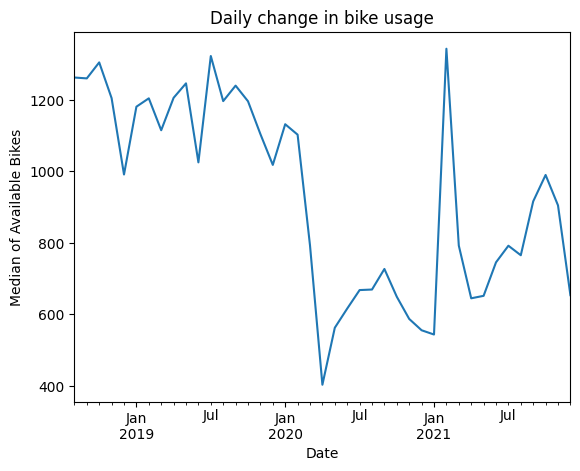

In [13]:
df_monthly = df_monthly.groupby('TIME').sum()
df_monthly['AVG BIKE USAGE'].plot(kind='line')
plt.title('Daily change in bike usage')
plt.xlabel('Date')
plt.ylabel('Median of Available Bikes')
plt.show()